In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

import scipy.stats
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
from copy import deepcopy
import numpy as np

device = torch.device("cpu")

from graph_plot_tools import smooth, group_uniques
from utils import *
from optimizers import clipped_SGD, clipped_SSTM

from IPython import display
from ipywidgets import Output
import time

from mpl_toolkits.axes_grid1 import make_axes_locatable

from joblib import Parallel, delayed

In [2]:
def smooth(a, eps=0.01, n_start=None):
    if n_start is not None and len(a) >= n_start:
        b = [np.array(a[:n_start]).mean()]
    else:
        b = [a[0]]
    for e in a[1:]:
        b.append(b[-1] * (1 - eps) + e * eps)
    return b


class ProgressParallel(Parallel):
    def __init__(self, *args, **kwargs):
        self._tqdm_total = kwargs.pop('tqdm_total', None)
        self._tqdm_leave = kwargs.pop('tqdm_leave', None)
        super().__init__(*args, **kwargs)

    def __call__(self, *args, **kwargs):
        with tqdm(total=self._tqdm_total, leave=self._tqdm_leave) as self._pbar:
            return Parallel.__call__(self, *args, **kwargs)

    def print_progress(self):
        if self._tqdm_total is None:
            self._pbar.total = self.n_dispatched_tasks
        self._pbar.n = self.n_completed_tasks
        self._pbar.refresh()

In [3]:
np.random.seed(42)

n, d = 10000, 100

A = np.random.laplace(0, 10.0, size=(n, d))
x_true = np.random.normal(scale=2.0, size=(d, 1))
y_true = A.dot(x_true)


A = torch.from_numpy(A)
x_true = torch.from_numpy(x_true)
y_true = torch.from_numpy(y_true)

y_true.shape

torch.Size([10000, 1])

In [4]:
def f(A, x, y_true, nu=0.5):
    y_pred = A.mm(x)
    return ((torch.abs(y_pred - y_true) ** (1 + nu)).mean())
#     return ((torch.abs(y_pred - y_true) ** (1 + nu)).mean()) ** (1 / (1 + nu))

mse_loss = torch.nn.MSELoss()
assert torch.isclose(mse_loss(A.mm(x_true + 1), y_true), f(A, x_true + 1, y_true, nu=1.0))

In [5]:
class FromMatricesDataset(Dataset):
    def __init__(self, A, w_true, y_true):
        """
        Args:
            A (n*d numpy array): A - dataset matix
            w_true (d numpy vector): w_true - vector to find
            y_true (n vector): labels
        """
        self.A = torch.from_numpy(A)
        self.w_true = torch.from_numpy(w_true)
        self.y_true = torch.from_numpy(y_true)

    def __len__(self):
        return self.A.shape[0]

    def dim(self):
        return self.A.shape[1]

    def __getitem__(self, idx):
        return (self.A[idx, :], self.y_true[idx])

    def to(self, device):
        self.A = self.A.to(device)
        self.w_true = self.w_true.to(device)
        self.y_true = self.y_true.to(device)
    
    
class LinearModel(object):
    def __init__(self, w):
        self.w = torch.from_numpy(w)
        self.w.requires_grad = True
        return

    def predict(self, A):
        return A.mm(self.w)

    def __call__(self, A):
        return self.predict(A)

    def parameters(self):
        return [self.w]

    def to(self, device):
        self.w = self.w.to(device)


class PNormFunction(object):
    def __init__(self, nu=1.0):
        self.nu = nu
        return
        
    def __call__(self, y_pred, y_true):
        return ((torch.abs(y_pred - y_true) ** (1 + self.nu)).mean())


A = np.random.normal(loc=0, scale=10.0, size=(n, d))
A = scipy.stats.levy.rvs(loc=0, scale=0.5, size=(n, d))
w_true = np.random.normal(scale=2.0, size=(d, 1))
w_pred = np.random.normal(scale=20.0, size=w_true.shape)
y_true = A.dot(w_true)

dataset = FromMatricesDataset(A, w_true, y_true)
model = LinearModel(w_pred + 1)
f = PNormFunction(1.0)

mse_loss = torch.nn.MSELoss()
mse_loss((dataset.A).mm(torch.from_numpy(w_pred) + 1), dataset.y_true)
assert torch.isclose(
    mse_loss((dataset.A).mm(torch.from_numpy(w_pred) + 1), dataset.y_true),
    f(model.predict(dataset.A), dataset.y_true)
)

### Generate dataset

In [6]:
n, d = 10000, 200
n_train = 5000
n_test = 5000

# batch_sizes = [1, 2, 5, 10, 20, 50, 100]
batch_sizes = [5, 10, 20, 50, 100, 200]
data_seeds = [x for x in range(0, 3)]
seeds = [x for x in range(0, 3)]

p = 0.75
loss_function = PNormFunction(p)




datas = {}
for data_seed in data_seeds:
    np.random.seed(data_seed)
    clip_l = 10000

    levy_data = scipy.stats.levy.rvs(loc=0, scale=0.5, size=(20 * n, 1))
    levy_data = levy_data[levy_data < clip_l][:, None]
    levy_data = levy_data - levy_data.mean()

    A = np.random.normal(loc=0, scale=1.0, size=(n, d)) * levy_data[:n, :]
    base_A = A / A.std(axis=0)

    w_true = np.random.normal(scale=1.0, size=(d, 1))
    w_pred = np.random.normal(scale=1.0, size=w_true.shape)
    w_true = w_true / np.linalg.norm(w_true) * 1.
    w_pred = w_pred / np.linalg.norm(w_pred) * 10.

    y_true_base = base_A.dot(w_true)
    y_true_base_with_noise = y_true_base + levy_data[n:2*n] / clip_l * 10
    
#     np.random.seed(data_seed)

    choice = np.random.choice(n, n_train + n_test, replace = False)
    
    A_temp = base_A[choice, :]
    A_train = A_temp[:n_train]
    A_test = A_temp[n_train:]

    y_true_train = y_true_base_with_noise[choice][:n_train]

    y_true_test = y_true_base[choice][n_train:]


    datas[data_seed] = (A_train, A_test, w_true, w_pred, y_true_train, y_true_test)


opt_name_to_class = {
    "adam": torch.optim.Adam,
    "sgd": torch.optim.SGD,
    "clipped_sgd": clipped_SGD,
    "clipped_sstm": clipped_SSTM,
}
        
optimizers_params = [
    {"opt_name": "clipped_sstm", "opt_params": {
        "lr": 1e-3, "L": 1.0, "clipping_type": "norm", "clipping_level": 0.01, "nu": 1.0
    }, "outer_params": {"batch_size":[5]}},
    # clipped_sgd
    {"opt_name": "clipped_sgd", "opt_params": {
        "lr": 1e-2, "momentum": 0.8, "clipping_type": "coordinate_wise", "clipping_level": 0.01
    }, "outer_params": {"batch_size":[5]}},
    # adam
    {"opt_name": "adam", "opt_params": {"lr": 1e-3, "betas":(0.9, 0.9)}, "outer_params": {"batch_size":[10]}},
    # sgd
    {"opt_name": "sgd", "opt_params": {"lr": 1e-4, "momentum": 0.99}, "outer_params": {"batch_size":[200]}},
]

def get_task_full_name(opt_params):
    return ", ".join(
        [opt_params["opt_name"]] + 
        ["{key}: {value}".format(key=key, value=opt_params["opt_params"][key]) for key in opt_params["opt_params"]] +  
        ["{key}: {value}".format(key=key, value=opt_params["outer_params"][key]) for key in opt_params["outer_params"]]
    )

def get_task_short_name(opt_params):
    return ", ".join(
        [opt_params["opt_name"]] + 
        ["{value}".format(value=opt_params["opt_params"][key]) for key in opt_params["opt_params"]] +  
        ["{value}".format(value=opt_params["outer_params"][key]) for key in opt_params["outer_params"]]
    )

tasks_params = []
for x in optimizers_params:
    local_batch_sizes = batch_sizes
    if "batch_size" in x["outer_params"]:
        if isinstance(x["outer_params"]["batch_size"], list):
            local_batch_sizes = x["outer_params"]["batch_size"]
        else:
            local_batch_sizes = [x["outer_params"]["batch_size"]]
    for bs in local_batch_sizes:
        y = deepcopy(x)
        y["outer_params"]["batch_size"] = bs
        y["task_name"] = get_task_full_name(y)
        y["task_short_name"] = get_task_short_name(y)
        tasks_params.append(y)

tasks = []
for data_seed in tqdm(data_seeds, total=len(data_seeds)):
    (A_train, A_test, w_true, w_pred, y_true_train, y_true_test) = datas[data_seed]
    training_data = FromMatricesDataset(A_train, w_true.copy(), y_true_train.copy())
    test_data = FromMatricesDataset(A_test, w_true.copy(), y_true_test.copy())

    for task_params in  tqdm(tasks_params, total=len(tasks_params), leave=False):
        for seed in seeds:
            torch.manual_seed(seed)

            train_dataloader = DataLoader(training_data, batch_size=task_params["outer_params"]["batch_size"], shuffle=True)
            train_dataloader_for_full_grad = DataLoader(training_data, batch_size=len(training_data), shuffle=False)
            test_dataloader = DataLoader(test_data, batch_size=len(test_data), shuffle=True)

            model = LinearModel(w_pred.copy())
            true_model = LinearModel(w_true.copy())

            optimizer = opt_name_to_class[task_params["opt_name"]](model.parameters(), **task_params["opt_params"])
            
            init_loss, train_loss_in_w_true = None, None
            with torch.no_grad():
                for data in train_dataloader_for_full_grad:
                    x, y_true = data[0], data[1]
                    y_pred = model.predict(x)
                    init_loss = loss_function(y_pred, y_true).detach().cpu().item()
                    del(x, y_true, y_pred)

                    x, y_true = data[0], data[1]
                    y_pred = true_model.predict(x)
                    train_loss_in_w_true = loss_function(y_pred, y_true).detach().cpu().item()
                    del(x, y_true, y_pred)
            
            tasks.append({
                "train_dataloader": train_dataloader,
                "train_dataloader_for_full_grad": train_dataloader_for_full_grad,
                "test_dataloader": test_dataloader,
                "model": model,
                "true_model": true_model,
                "optimizer": optimizer,
                "task_params": task_params,
                "init_loss": init_loss,
                "train_loss_in_w_true": train_loss_in_w_true
            })
        
print("Number of tasks: {}".format(len(tasks)))

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Number of tasks: 36


In [7]:
tasks[0]

{'train_dataloader': <torch.utils.data.dataloader.DataLoader at 0x7f859e02c370>,
 'train_dataloader_for_full_grad': <torch.utils.data.dataloader.DataLoader at 0x7f859e02c490>,
 'test_dataloader': <torch.utils.data.dataloader.DataLoader at 0x7f859e02c580>,
 'model': <__main__.LinearModel at 0x7f859e02c670>,
 'true_model': <__main__.LinearModel at 0x7f864806c850>,
 'optimizer': clipped_SSTM (
 Parameter Group 0
     L: 1.0
     a_k_ratio_upper_bound: 1.0
     clipping_level: 0.01
     clipping_type: norm
     lr: 0.001
     nu: 1.0
     state: {}
 ),
 'task_params': {'opt_name': 'clipped_sstm',
  'opt_params': {'lr': 0.001,
   'L': 1.0,
   'clipping_type': 'norm',
   'clipping_level': 0.01,
   'nu': 1.0},
  'outer_params': {'batch_size': 5},
  'task_name': 'clipped_sstm, lr: 0.001, L: 1.0, clipping_type: norm, clipping_level: 0.01, nu: 1.0, batch_size: 5',
  'task_short_name': 'clipped_sstm, 0.001, 1.0, norm, 0.01, 1.0, 5'},
 'init_loss': 26.240387279274785,
 'train_loss_in_w_true': 0.13

In [9]:
task_number = 20

with torch.no_grad():
    print(
        loss_function(
        tasks[task_number]["model"].predict(tasks[task_number]["train_dataloader"].dataset.A), 
        tasks[task_number]["train_dataloader"].dataset.y_true
        ).detach().cpu().item()
    )
    print(
        loss_function(
        tasks[task_number]["true_model"].predict(tasks[task_number]["train_dataloader"].dataset.A), 
        tasks[task_number]["train_dataloader"].dataset.y_true
        ).detach().cpu().item()
    )

25.71105190432585
0.15488874951165213


In [10]:
tasks[task_number]["train_loss_in_w_true"]

0.15488874951165213

In [11]:
def recursive_to(param, device):
    # Not sure if there are any global tensors in the state dict
    if isinstance(param, torch.Tensor):
        param.data = param.data.to(device)
        if param._grad is not None:
            param._grad.data = param._grad.data.to(device)
    elif isinstance(param, dict):
        for subparam in param.values():
            recursive_to(subparam, device)
    elif isinstance(param, list):
        for subparam in param:
            recursive_to(subparam, device)

def optimizer_to(optim, device):
    for param_group in optim.param_groups:
        for param in param_group.values():
            # Not sure there are any global tensors in the state dict
            recursive_to(param, device)
            
def task_to(task, device):
    optimizer_to(task["optimizer"], device)
    task["model"].to(device)
    task["true_model"].to(device)
    task["train_dataloader"].dataset.to(device)
    task["test_dataloader"].dataset.to(device)
    task["train_dataloader_for_full_grad"].dataset.to(device)
    return

def add_to_losses(loss_hist, new_loss):
    loss_hist["ys"].append(new_loss)
    if len(loss_hist["xs"]) == 0:
        loss_hist["xs"].append(0)
    else:
        loss_hist["xs"].append(loss_hist["xs"][-1] + loss_hist["x_step"])
    return 

def add_to_norm_diffs(norm_diffs_hist, norm_diffs, epoch):
    norm_diffs_hist["diffs"].append(norm_diffs)
    if len(norm_diffs_hist["xs"]) == 0:
        norm_diffs_hist["xs"].append(0)
    else:
        norm_diffs_hist["xs"].append(norm_diffs_hist["xs"][-1] + norm_diffs_hist["x_step"])
    norm_diffs_hist["epochs"].append(epoch)
    return 

In [12]:
import scipy
from scipy import stats
from tqdm.notebook import tqdm

def get_batch_grad(model):
    gr=[]
    for i in model.parameters():
        if i.requires_grad:
            gr.append(i.grad.view(-1))
    return torch.cat(gr)


def get_loss(model, criterion, batch):
    x, y_true = batch[0], batch[1]
    y_pred = model.predict(x)
    loss = criterion(y_true, y_pred)
    return loss


def compute_full_grad(model, optimizer, criterion, dataloader_for_full_grad):
    fully_grad = []
    optimizer.zero_grad()

#     print("Computing full gradient")
    with tqdm(total=len(dataloader_for_full_grad), leave=False) as pbar:
        for step, batch in enumerate(dataloader_for_full_grad, start=1):
            loss = get_loss(model, criterion, batch)
            loss.backward()

            if fully_grad != []:
                fully_grad = fully_grad + get_batch_grad(model) * \
                    dataloader_for_full_grad.batch_size
            else:
                fully_grad = get_batch_grad(model) * dataloader_for_full_grad.batch_size
            optimizer.zero_grad()

            pbar.update(1)
    return fully_grad / (step * dataloader_for_full_grad.batch_size)


def compute_norm_diffs(model, optimizer, criterion, dataloader_for_full_grad, dataloader, full_grad=None, 
                       repeats=1, batches=10000):
    if full_grad is None:
        full_grad = compute_full_grad(model, optimizer, criterion, dataloader_for_full_grad)
    mini_norms = []
    optimizer.zero_grad()
#     print("Computing norm diffs")
    repeats = 0
    with tqdm(total=batches, leave=False) as pbar:
        for _ in range((batches + len(dataloader) - 1) // len(dataloader)):
            for step, batch in enumerate(dataloader):
                loss = get_loss(model, criterion, batch)
                loss.backward()

                mini_norms.append((get_batch_grad(model) - full_grad).norm().item())
                optimizer.zero_grad()

                pbar.update(1)
                
                repeats += 1
                if repeats == batches:
                    break

    return np.array(mini_norms)

In [13]:
def group_uniques(tasks_history, norm_train=False):
    norm_train_modifier = 1.0
        
    groups = {}
    for hist in tasks_history:
        if not (hist["name"] in groups):
            groups[hist["name"]] = {"short_name":hist["short_name"], "losses":{}, "norm_diff":None}
        group_losses = groups[hist["name"]]["losses"]
        for loss_name in hist["losses"]:
            if not (loss_name in group_losses):
                group_losses[loss_name] = {}
                group_losses[loss_name]["max_len"] = 0
            group_losses[loss_name]["max_len"] = max(
                group_losses[loss_name]["max_len"], 
                len(hist["losses"][loss_name]["ys"])
            )

    for hist in tasks_history:
        if groups[hist["name"]]["norm_diff"] is None:
            groups[hist["name"]]["norm_diff"] = {"diffs": [], "xs": [], "x_step": -1, "epochs": []}
        h_group = groups[hist["name"]]["norm_diff"]
        h = hist["norm_diff"]

        groups[hist["name"]]["norm_diff"]["xs"] = \
            h["xs"] if len(h["xs"]) > len(h_group["xs"]) else h_group["xs"]

        groups[hist["name"]]["norm_diff"]["x_step"] = h["x_step"]

        groups[hist["name"]]["norm_diff"]["epochs"] = \
            h["epochs"] if len(h["epochs"]) > len(h_group["epochs"]) else h_group["epochs"]

        if len(groups[hist["name"]]["norm_diff"]["diffs"]) == 0:
            groups[hist["name"]]["norm_diff"]["diffs"] = [[t] for t in h["diffs"]]
        else:
            for norm_diffs_i, norm_diffs in enumerate(h["diffs"]):
                groups[hist["name"]]["norm_diff"]["diffs"][norm_diffs_i].append(norm_diffs)
    
    for group_name in groups:
        group = groups[group_name]
        for loss_name in group["losses"]:
            group_loss = group["losses"][loss_name]
            group_loss["ys"] = np.zeros(group_loss["max_len"])
            group_loss["xs"] = np.zeros(group_loss["max_len"])
            group_loss["count"] = np.zeros(group_loss["max_len"])
            group_loss["x_step"] = -1
    
    for hist in tasks_history:
        group = groups[hist["name"]]
        
        if norm_train:
            norm_train_modifier = hist["train_loss_in_w_true"]

        for loss_name in hist["losses"]:
            group_loss = group["losses"][loss_name]
            loss = hist["losses"][loss_name]
            loss_ys, loss_xs = np.array(loss["ys"]), np.array(loss["xs"])
            if "train" in loss_name:
                loss_ys = loss_ys / norm_train_modifier
            n = loss_ys.shape[0]
            group_loss["ys"][:n] += loss_ys
            group_loss["xs"][:n] += loss_xs
            group_loss["count"][:n] += 1.0
            group_loss["x_step"] = loss["x_step"]
        if "task_params" in hist:
            group["task_params"] = hist["task_params"]
        else:
            group["task_params"] = {}
    
    for group_name in groups:
        group = groups[group_name]
        for loss_name in group["losses"]:
            group_loss = group["losses"][loss_name]
            group_loss["ys"] /= group_loss["count"]
            group_loss["xs"] /= group_loss["count"]

        for norm_diffs_group_i, norm_diffs_group in enumerate(group["norm_diff"]["diffs"]):
            means = []
            stds = []
            for norm_diffs_i, norm_diffs in enumerate(norm_diffs_group):
                means.append(norm_diffs.mean())
                stds.append(norm_diffs.std())
                norm_diffs_group[norm_diffs_i] = (norm_diffs - norm_diffs.mean()) / norm_diffs.std()
            mean = np.mean(means)
            std = np.mean(stds)
            group["norm_diff"]["diffs"][norm_diffs_group_i] = np.concatenate(norm_diffs_group) * std + mean

    return groups


def make_loss_plot(ax, tasks_history_grouped, loss_name, loss_title_name,
                x_label="Iteration", start_x=0, end_x=None, alpha=0.8, linestyle="-", eps=0.01, legend=False,
                x_scale="linear", y_scale="linear", smooth_n_start=None, n_train=5000, eps_auto=False):
    if len(tasks_history_grouped) < 7:
        colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
    else:
        cmap = plt.get_cmap('hsv')
        colors = cmap(np.linspace(0, 0.9, len(tasks_history_grouped)))

    plot_params = {"alpha":alpha, "linestyle":linestyle}
    

    for i, group_name in enumerate(tasks_history_grouped):
        group = tasks_history_grouped[group_name]["losses"]
        xs = group[loss_name]["xs"][start_x:end_x]
        ys = group[loss_name]["ys"][start_x:end_x]
        if eps_auto:
            local_eps = eps / (n_train / group[loss_name]["x_step"])
        else:
            local_eps = eps
        smoothed_ys = smooth(ys, eps=local_eps, n_start=smooth_n_start)
        group_name_for_legend = group_name
        if "short_name" in tasks_history_grouped[group_name]:
            group_name_for_legend = tasks_history_grouped[group_name]["short_name"]
        ax.plot(
            xs, smoothed_ys, label=group_name_for_legend, color=colors[i], 
            **plot_params
        )

    ax.set_title("{} for different tasks".format(loss_title_name))
    ax.set_ylabel("{}".format(loss_title_name))
    ax.set_xlabel(x_label)
    ax.set_xscale(x_scale)
    ax.set_yscale(y_scale)
    ax.grid(True)
    plt.tight_layout()
    if legend:
        ax.legend()

    return ax


def draw_norm_hist(ax, norm_diffs, bins_n=100, draw_normal=True):
    counts, bins = np.histogram(norm_diffs, bins_n, density=True)

    if draw_normal:
        mu = np.mean(norm_diffs)
        sigma = np.sqrt(np.mean((norm_diffs - mu)**2))
        temp2 = np.linspace(bins[0], bins[-1], bins_n)
        y = scipy.stats.norm.pdf(temp2, mu, sigma)
        temp2 = temp2[y > (counts[counts > 0]).min()]

        ax.plot(
            temp2, scipy.stats.norm.pdf(temp2, mu, sigma), 
            linewidth=2, color='red'
        )

    ax.hist(bins[:-1], bins, weights=counts)

    return ax


def draw_norm_hists_for_different_models(fig, subplotspec_outer, tasks_history_grouped, bins_n=100, draw_normal=True, number=-1):
    h = (len(tasks_history_grouped) + 2) // 3
    sgs = subplotspec_outer.subgridspec(h, 3, wspace=0.15, hspace=0.6)
    for i, group_name in enumerate(tasks_history_grouped):
        group = tasks_history_grouped[group_name]["norm_diff"]
        ax = fig.add_subplot(sgs[i // 3, i % 3])
        if len(group["diffs"]) > 0:
            ax = draw_norm_hist(ax, group["diffs"][number], bins_n=bins_n, draw_normal=draw_normal)
            label = group_name
            ax.set_title("{},\n batch_count={}, skew={:0.2f}".format(
                label, 
                len(group["diffs"][number]), 
                stats.skew(group["diffs"][number])
            ), fontsize=11)
        ax.set_ylabel("Density")
        ax.set_xlabel("Noise norm")
        ax.grid(True)

    ax = plt.Subplot(fig, subplotspec_outer)
    ax.set_title("Distribution of the gradient noise for different optimizers", y=1.15, fontsize=14)
    ax.set_frame_on(False)
    ax.axis('off')
    fig.add_subplot(ax)

    return ax

In [14]:
calc_norm_diffs = True
calc_norm_diffs = False

epochs_total = 10
n_jobs = 4

out = Output()
display.display(out)

tasks_history = []
for task in tasks:
    task_to(task, device)
    tasks_history.append({
        "name": task["task_params"]["task_name"],
        "short_name": task["task_params"]["task_short_name"],
        "losses": {
            "train_losses": {
                "ys": [task["init_loss"]], 
                "xs": [0], 
                "x_step": task["task_params"]["outer_params"]["batch_size"]
            },
            "test_losses": {
                "ys": [], "xs": [], "x_step": 1
            },
            "train_losses_full": {
                "ys": [], "xs": [], "x_step": 1
            },
            "pred_w_true_w_norm_diff": {
                "ys": [], "xs": [], "x_step": 1
            },
        },
        "norm_diff": {
            "diffs": [], "xs": [], "x_step": 1, "epochs": []
        },
        "train_loss_in_w_true": task["train_loss_in_w_true"],
        "train_loss_init": task["init_loss"],
        "task_params": task["task_params"]
    })

tasks_pairs = list(zip(tasks, tasks_history))

def mapper(epoch, task, hist):
    # /Loading task
#         task_to(task, device)
    optimizer = task["optimizer"]
    model = task["model"]
    true_model = task["true_model"]
    train_dataloader = task["train_dataloader"]
    train_dataloader_for_full_grad = task["train_dataloader_for_full_grad"]
    test_dataloader = task["test_dataloader"]
    # Loading task/

    # /Saving current weights diff
    add_to_losses(
        hist["losses"]["pred_w_true_w_norm_diff"],
        ((((model.w - true_model.w)**2).sum()).detach().cpu().item()) ** 0.5
    )
    # Saving current weights diff/

    # /Compute norm diffs distribution on train dataset
    if calc_norm_diffs and epoch % 40 == 0:
        norm_diffs = compute_norm_diffs(
            model, optimizer, loss_function, 
            train_dataloader_for_full_grad, train_dataloader, batches=10000
        )

        add_to_norm_diffs(
            hist["norm_diff"], 
            norm_diffs, 
            epoch
        )
    # Compute norm diffs distribution on train dataset/

    # /Validation
    with torch.no_grad():
        for data in test_dataloader:
            x, y_true = data[0], data[1]
            y_pred = model.predict(x)
            loss = loss_function(y_pred, y_true)
            add_to_losses(hist["losses"]["test_losses"], loss.detach().cpu().item())
            del(x, y_true, y_pred, loss)
    # Validation/

    # /Train loss full
    with torch.no_grad():
        for data in train_dataloader_for_full_grad:
            x, y_true = data[0], data[1]
            y_pred = model.predict(x)
            loss = loss_function(y_pred, y_true)
            add_to_losses(hist["losses"]["train_losses_full"], loss.detach().cpu().item())
            del(x, y_true, y_pred, loss)
    # Train loss full/

    # /Train
    for data in train_dataloader:
        x, y_true = data[0], data[1]
        y_pred = model.predict(x)
        loss = loss_function(y_pred, y_true)
        loss.backward()

        optimizer.step()
        optimizer.zero_grad()

        add_to_losses(hist["losses"]["train_losses"], loss.detach().cpu().item())
        del(x, y_true, y_pred, loss)
    # Train/

#     task_to(task, "cpu")
    return (task, hist)
    

for epoch in tqdm(range(0, epochs_total), total=epochs_total):
    # train/validate/get norm diffs
    tasks_pairs = list(
        ProgressParallel(
            n_jobs, tqdm_total=len(tasks_pairs), tqdm_leave=False, backend='threading'
        )(
            delayed(mapper)(epoch, task, hist) for (task, hist) in tasks_pairs
        )
    )

    train_smooth = 0.01
    test_losses_threshold = 1e4
    train_losses_full_threshold = 1e8
    top_k_groups = 3
    with out:
        if epoch % 1 == 0:
            # remove tasks that can't converge
            new_tasks, new_tasks_history = [], []
            for task, hist in tasks_pairs:
    #             if smooth(hist["losses"]["test_losses"]["ys"], 1.0)[-1] < 1e4:
#                 if hist["losses"]["test_losses"]["ys"][-1] < test_losses_threshold:
                if hist["losses"]["train_losses_full"]["ys"][-1] < train_losses_full_threshold:
                    new_tasks.append(task)
                    new_tasks_history.append(hist)
                else:
                    del(task, hist)
            tasks = new_tasks
            tasks_history = new_tasks_history
            # /remove tasks that can't converge

            tasks_history_grouped = group_uniques(tasks_history, norm_train=True)
            tasks_history_grouped = [
                (k, tasks_history_grouped[k]) for k in tasks_history_grouped
            ]
            # display best only
            def key(h, alpha=0.01):
                return h[1]["losses"]["train_losses_full"]["ys"][-1]
#                 return smooth(
#                     h[1]["losses"]["train_losses"]["ys"], 
#                     1.0 / (n_train / h[1]["losses"]["train_losses"]["x_step"])
#                 )[-1]

            tasks_history_grouped = sorted(tasks_history_grouped, key=key)

            def select_top(tasks_history_loaded_grouped, algos, top_k=3):
                if algos is None:
                    algos = set()
                    for hist in tasks_history_loaded_grouped:
                        algos.add(hist[0].split(",")[0])
                
                res_count = dict([(name, 0) for name in algos])
                res = []
                for name in algos:
                    for hist in tasks_history_grouped:
                        if name == hist[0].split(",")[0] and res_count[name] < top_k:
                            res.append(hist)
                            res_count[name] += 1
                return res

            tasks_history_grouped = select_top(
                tasks_history_grouped, 
                ["clipped_sstm", "clipped_sgd", "sgd", "adam"],
                top_k=top_k_groups
            )
            tasks_history_grouped = sorted(tasks_history_grouped, key=key)
            tasks_history_grouped = dict(tasks_history_grouped)
            # /display best only

            display.clear_output(wait=True)

            fig = plt.figure(figsize=(16,18))
            gs = plt.GridSpec(7,4, figure=fig)

            ax1 = fig.add_subplot(gs[0:2,0:2])

            make_loss_plot(
                ax1, tasks_history_grouped, "train_losses", "train_losses", 
                x_label="Samples", 
                start_x=0, alpha=0.9, linestyle="-", eps=1.0, y_scale="log", eps_auto=True,
            )

            ax2 = fig.add_subplot(gs[0:2,2:4])

            make_loss_plot(
                ax2, tasks_history_grouped, "test_losses", "test_losses", 
                x_label="Epochs", 
                start_x=0, alpha=0.9, linestyle="-", eps=1.0, y_scale="log"
            )

            ax3 = fig.add_subplot(gs[2:4,0:2])

            make_loss_plot(
                ax3, tasks_history_grouped, "train_losses_full", "train_losses_full", 
                x_label="Epochs", 
                start_x=0, alpha=0.9, linestyle="-", eps=1.0, y_scale="log"
            )

            ax4 = fig.add_subplot(gs[2:4,2:4])

            make_loss_plot(
                ax4, tasks_history_grouped, "pred_w_true_w_norm_diff", "||w_true - w_pred||_2", 
                x_label="Epochs", 
                start_x=0, alpha=0.9, linestyle="-", eps=1.0, legend=True, y_scale="log"
            )

            if calc_norm_diffs:
                draw_norm_hists_for_different_models(fig, gs[4:,:], tasks_history_grouped, bins_n=100, draw_normal=True)

            fig.tight_layout()

            plt.show()

Output()

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

### Save models / train data

In [15]:
from datetime import datetime

now = datetime.now()
now = str(now)

In [16]:
save_net_weights = False


if save_net_weights:
    for i in range(len(nets)):
        if "/" in hist[i]["name"]:
            hist[i]["name"] = ":".join(hist[i]["name"].split("/"))
        PATH = './models/bert_{}.pth'.format(
            "_".join(now.split(" ")[0:1] + now.split(" ")[1].split(".")[0].split(":") + hist[i]["name"].split())
        )
        torch.save(nets[0].state_dict(), PATH)

In [17]:
from copy import deepcopy

hist3 = deepcopy(tasks_history)

In [18]:
def rec_to_json(hist):
    if isinstance(hist, dict):
        for key in hist:
            hist[key] = rec_to_json(hist[key])
    elif isinstance(hist, list):
        return [rec_to_json(x) for x in hist]
    elif isinstance(hist, np.ndarray):
        return [rec_to_json(x) for x in hist]
    else:
        hist = str(hist)
    return hist
    
hist3 = rec_to_json(hist3)

In [19]:
import json
import os

# filename = './results/synthetic/{}_train_hist_p_{}_grid_search.json'.format(
#     "_".join(now.split(" ")[0:1] + now.split(" ")[1].split(".")[0].split(":")),
#     p
# )
filename = './results/synthetic/{}_train_hist_p_{}_selected_by_train_loss_full.json'.format(
    "_".join(now.split(" ")[0:1] + now.split(" ")[1].split(".")[0].split(":")),
    p
)
          
os.makedirs(os.path.dirname(filename), exist_ok=True)
with open(filename, 'w') as fout:
    json.dump(hist3 , fout)

### Load models / train data

In [20]:
import ast

def load_hist_jsons(hists_names_list, path="./models"):
    hists = []
    for hist_name in hists_names_list:
        with open(r"{}/{}.json".format(path, hist_name), "r") as read_file:
            hist = json.load(read_file)
            hists += hist
    return hists


def rec_hist_from_json(hist, l_level=0):
    if isinstance(hist, dict):
        for key in hist:
            hist[key] = rec_hist_from_json(hist[key])
    elif isinstance(hist, list) and l_level==0:
        return [rec_hist_from_json(x, l_level=1) for x in hist]
    elif isinstance(hist, list) and l_level==1:
        return np.array([rec_hist_from_json(x, l_level=1) for x in hist])
    elif isinstance(hist, np.ndarray):
        return [rec_hist_from_json(x) for x in hist]
    else:
        try:
            hist = int(hist)
        except ValueError:
            try:
                hist = float(hist)
            except ValueError:
                hist = str(hist)
    return hist


def hist_from_json(hists):
    for h in hists:
        for key in h:
            if key != "name":
                h[key] = rec_hist_from_json(h[key])
    return hists

In [26]:
import json

hists_names_list = [
    "2022-06-28_20_19_55_train_hist_p_0.75_selected_by_train_loss_full"
    
]

tasks_history_loaded = hist_from_json(load_hist_jsons(hists_names_list, path="./results/synthetic/"))

In [27]:
# tasks_history_loaded_grouped = group_uniques(tasks_history_loaded)
tasks_history_loaded_grouped = group_uniques(tasks_history_loaded, norm_train=True)
tasks_history_loaded_grouped = [(k, tasks_history_loaded_grouped[k]) for k in tasks_history_loaded_grouped]

In [28]:


def key(h):
#     a = np.array(h[1]["losses"]["train_losses_full"]["ys"])
#     a = a < 1.0 * 2.0
#     res = 0
#     for i in range(a.shape[0] - 1, -1, -1):
#         if not a[i]:
#             break
#         res += 1
#     return (-res, h[1]["losses"]["train_losses_full"]["ys"][-1])
    
    return h[1]["losses"]["train_losses_full"]["ys"][-1]

for group in tasks_history_loaded_grouped:
    print(group[0], ": ", group[1]["losses"]["train_losses"]["count"][0], key(group))

# grouped_hist = grouped_hist[0:4]

tasks_history_loaded_grouped = sorted(tasks_history_loaded_grouped, key=key)

def select_top(tasks_history_loaded_grouped, algos, top_k=1):
    res_count = dict([(name, 0) for name in algos])
    res = []
    for name in algos:
        for hist in tasks_history_loaded_grouped:
            if name == hist[0].split(",")[0] and res_count[name] < top_k:
                res.append(hist)
                res_count[name] += 1
    return res

tasks_history_loaded_grouped = select_top(tasks_history_loaded_grouped, 
                                          ["clipped_sstm", "clipped_sgd", "sgd", "adam"], 
                                          top_k=3)

tasks_history_loaded_grouped = sorted(tasks_history_loaded_grouped, key=key)
tasks_history_loaded_grouped = dict(tasks_history_loaded_grouped)


clipped_sstm, lr: 0.001, L: 1.0, clipping_type: norm, clipping_level: 0.01, nu: 1.0, batch_size: 5 :  9.0 14.308970214148205
clipped_sgd, lr: 0.01, momentum: 0.8, clipping_type: coordinate_wise, clipping_level: 0.01, batch_size: 5 :  9.0 86.02884052241579
adam, lr: 0.001, betas: (0.9, 0.9), batch_size: 10 :  9.0 56.58552769676318
sgd, lr: 0.0001, momentum: 0.99, batch_size: 200 :  9.0 35.187418841497745


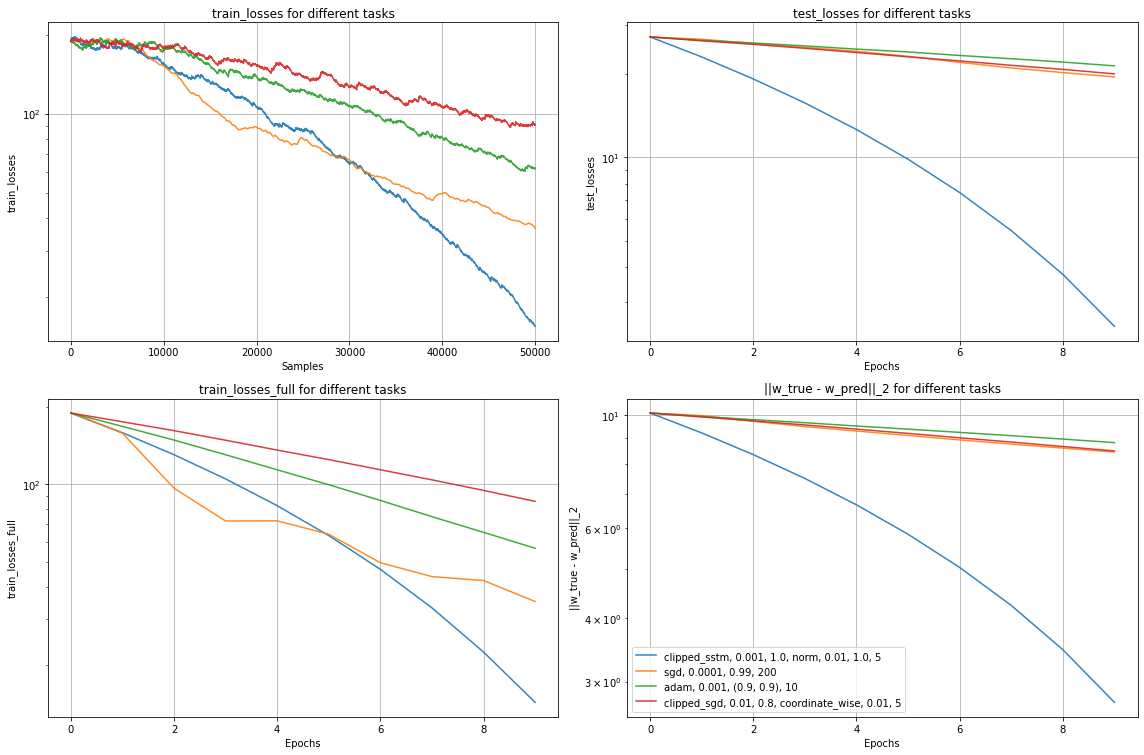

In [29]:
fig = plt.figure(figsize=(16,18))
gs = plt.GridSpec(7,4, figure=fig)

ax1 = fig.add_subplot(gs[0:2,0:2])

make_loss_plot(
    ax1, tasks_history_loaded_grouped, "train_losses", "train_losses", 
    x_label="Samples", 
    start_x=0, alpha=0.9, linestyle="-", eps=1.0, y_scale="log", eps_auto=True,
)

ax2 = fig.add_subplot(gs[0:2,2:4])

make_loss_plot(
    ax2, tasks_history_loaded_grouped, "test_losses", "test_losses", 
    x_label="Epochs", 
    start_x=0, alpha=0.9, linestyle="-", eps=1.0, y_scale="log"
)

ax3 = fig.add_subplot(gs[2:4,0:2])

make_loss_plot(
    ax3, tasks_history_loaded_grouped, "train_losses_full", "train_losses_full", 
    x_label="Epochs", 
    start_x=0, alpha=0.9, linestyle="-", eps=1.0, y_scale="log"
)

ax4 = fig.add_subplot(gs[2:4,2:4])

make_loss_plot(
    ax4, tasks_history_loaded_grouped, "pred_w_true_w_norm_diff", "||w_true - w_pred||_2", 
    x_label="Epochs", 
    start_x=0, alpha=0.9, linestyle="-", eps=1.0, legend=True, y_scale="log"
)

calc_norm_diffs = True
calc_norm_diffs = False

if calc_norm_diffs:
    draw_norm_hists_for_different_models(
        fig, gs[4:,:], tasks_history_loaded_grouped, 
        bins_n=100, draw_normal=True)

plt.tight_layout()

plt.show()

### Norm diffs

In [56]:
import json

hists_names_list = [
    "2022-05-29_22_02_03_train_hist_p_0.0_initial_norm_hists",
    "2022-05-29_22_35_50_train_hist_p_0.25_initial_norm_hists",
    "2022-05-29_23_03_48_train_hist_p_0.5_initial_norm_hists",
    "2022-05-30_00_49_07_train_hist_p_0.75_initial_norm_hists",
    "2022-05-30_01_18_46_train_hist_p_1.0_initial_norm_hists",
]

ps = [0, 0.25, 0.5, 0.75, 1.0]

# hists_names_list = hists_names_list[::-1]

p_to_hist = {}
for p, hist_name in zip(ps, hists_names_list):
    p_to_hist[p] = hist_from_json(load_hist_jsons([hist_name], path="./results/synthetic/"))

In [57]:
def draw_norm_hists_for_different_p(fig, subplotspec_outer, tasks_history_grouped, bins_n=100, draw_normal=True, number=-1, p=0.0):
    h = len(tasks_history_grouped)
    sgs = subplotspec_outer.subgridspec(h, 1, wspace=-0.1, hspace=0.5)
    for i, group_name in enumerate(tasks_history_grouped):
        group = tasks_history_grouped[group_name]["norm_diff"]
        ax = fig.add_subplot(sgs[i, 0])
#         print(len(group["diffs"][number]))
        if len(group["diffs"]) > 0:
            ax = draw_norm_hist(ax, group["diffs"][number], bins_n=bins_n, draw_normal=draw_normal)
            label = group_name
            ax.set_title("batch_size={}, p={}".format(
                tasks_history_grouped[group_name]["task_params"]["outer_params"]["batch_size"], 
                p
            ), fontsize=14)
        ax.set_ylabel("Density", fontsize=14)
        ax.set_xlabel("Noise norm", fontsize=14)
        ax.grid(True)

    ax = plt.Subplot(fig, subplotspec_outer)
#     ax.set_title("Distribution of the gradient noise for different optimizers", y=1.15, fontsize=14)
    ax.set_frame_on(False)
    ax.axis('off')
    fig.add_subplot(ax)

    return ax

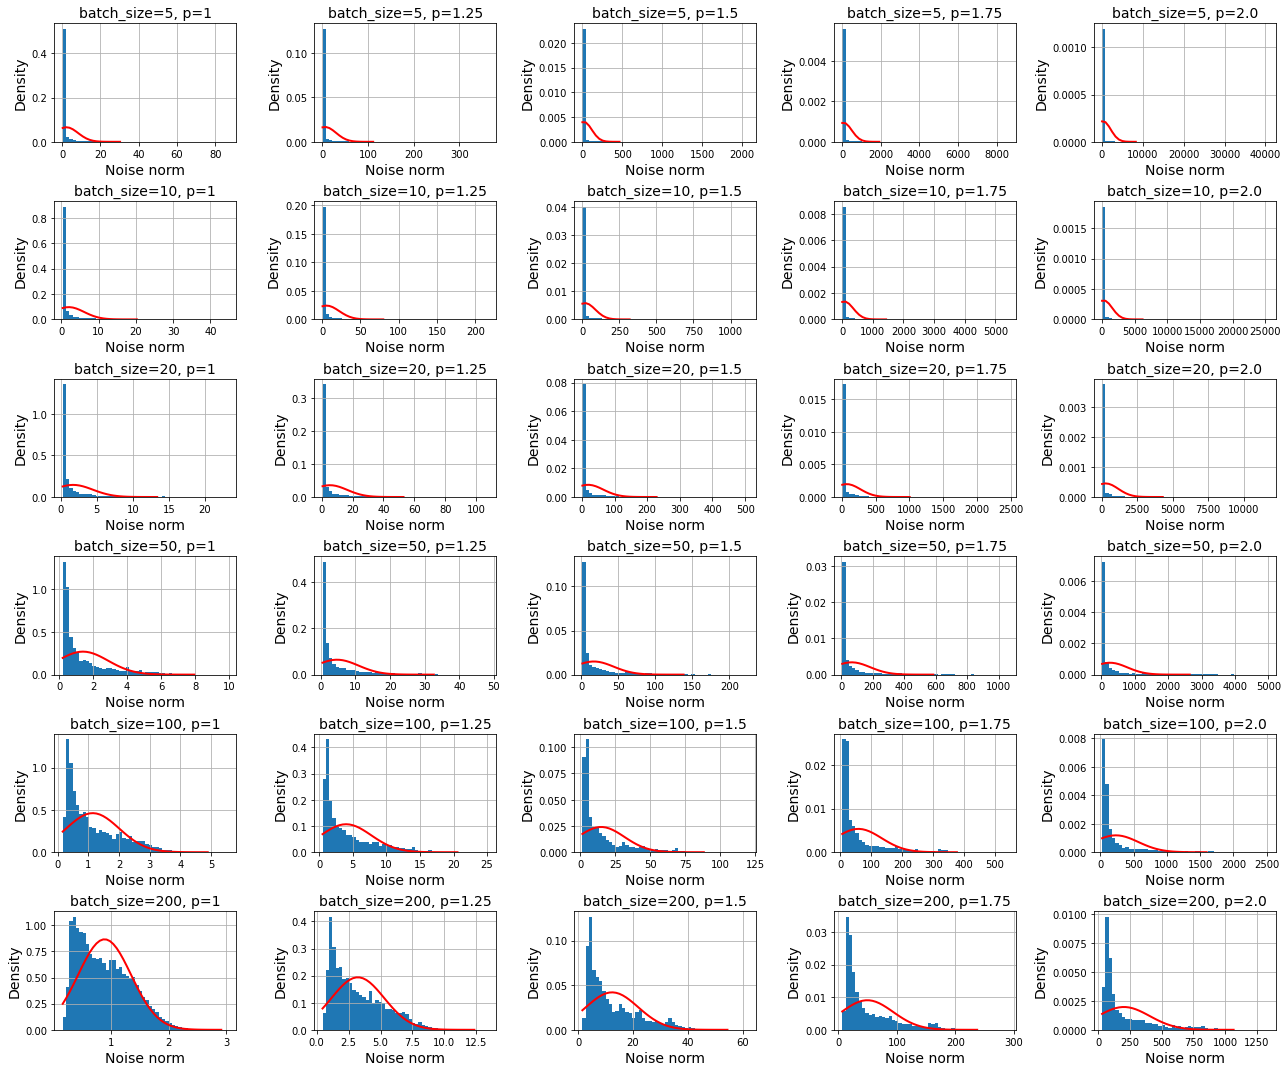

In [58]:
fig = plt.figure(figsize=(18,15))
gs = plt.GridSpec(6,5, figure=fig)

for i,p in enumerate(ps):
    tasks_history_loaded = p_to_hist[p]

    tasks_history_loaded_grouped = group_uniques(tasks_history_loaded, norm_train=True)
#     tasks_history_loaded_grouped = [(k, tasks_history_loaded_grouped[k]) for k in tasks_history_loaded_grouped]

    calc_norm_diffs = True

    if calc_norm_diffs:
        draw_norm_hists_for_different_p(
            fig, gs[:, i], tasks_history_loaded_grouped, 
            bins_n=50, draw_normal=True, p=p + 1
        )

# plt.title("Distribution of the gradient noise for different optimizers", fontsize=14)

plt.tight_layout()

PATH = './graphs/synth/synth_norm_diffs_p_bs.pdf'

plt.savefig(PATH, format='pdf')

### Plot best wrt best score

In [21]:
import ast

def load_hist_jsons(hists_names_list, path="./models"):
    hists = []
    for hist_name in hists_names_list:
        with open(r"{}/{}.json".format(path, hist_name), "r") as read_file:
            hist = json.load(read_file)
            hists += hist
    return hists


def rec_hist_from_json(hist, l_level=0):
    if isinstance(hist, dict):
        for key in hist:
            hist[key] = rec_hist_from_json(hist[key])
    elif isinstance(hist, list) and l_level==0:
        return [rec_hist_from_json(x, l_level=1) for x in hist]
    elif isinstance(hist, list) and l_level==1:
        return np.array([rec_hist_from_json(x, l_level=1) for x in hist])
    elif isinstance(hist, np.ndarray):
        return [rec_hist_from_json(x) for x in hist]
    else:
        try:
            hist = int(hist)
        except ValueError:
            try:
                hist = float(hist)
            except ValueError:
                hist = str(hist)
    return hist


def hist_from_json(hists):
    for h in hists:
        for key in h:
            if key != "name":
                h[key] = rec_hist_from_json(h[key])
    return hists

In [22]:
def make_loss_plot_with_plot_params(ax, tasks_history_grouped, loss_name, loss_title_name,
                x_label="Iteration", y_label="Loss", start_x=0, end_x=None, alpha=0.8, linestyle="-", eps=0.01, legend=False,
                x_scale="linear", y_scale="linear", smooth_n_start=None, n_train=5000, eps_auto=False,
                plot_params=None, mark_every_count=15, xy_label_fontsize=10, title_fontsize=14,
                use_long_name=False):
    if len(tasks_history_grouped) < 7:
        colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
    else:
        cmap = plt.get_cmap('hsv')
        colors = cmap(np.linspace(0, 0.9, len(tasks_history_grouped)))

#     plot_params = {"alpha":alpha, "linestyle":linestyle}
    

    for i, group_name in enumerate(tasks_history_grouped):
        for key in plot_params:
            if key == group_name.split(",")[0]:
                local_plot_params = plot_params[key].copy()
                break
        group = tasks_history_grouped[group_name]["losses"]
        xs = group[loss_name]["xs"][start_x:end_x]
        ys = group[loss_name]["ys"][start_x:end_x]
        if eps_auto:
            local_eps = eps / (n_train / group[loss_name]["x_step"])
        else:
            local_eps = eps
        smoothed_ys = smooth(ys, eps=local_eps, n_start=smooth_n_start)
        group_name_for_legend = group_name
        if not use_long_name:
            if "short_name" in tasks_history_grouped[group_name]:
                group_name_for_legend = tasks_history_grouped[group_name]["short_name"]
            if "name" in local_plot_params:
                group_name_for_legend = local_plot_params.pop("name")
        else:
            local_plot_params.pop("name")

        if "markevery" in local_plot_params and local_plot_params["markevery"] == "auto":
            mark_every = len(xs) // (mark_every_count + 1)
            local_plot_params["markevery"] = np.arange((i * mark_every) // (len(tasks_history_grouped)), len(xs), mark_every)

        ax.plot(
            xs, smoothed_ys, label=group_name_for_legend, # color=colors[i], 
            **local_plot_params
        )
#     plt.rc('font', size=xy_label_fontsize)
#     ax.ticklabel_format(style='sci', axis='x', scilimits=(0,0))

    ax.set_title("{}".format(loss_title_name), fontsize=title_fontsize)
    ax.set_xlabel(x_label, fontsize=xy_label_fontsize)
    ax.set_ylabel(y_label, fontsize=xy_label_fontsize)
    ax.set_xscale(x_scale)
    ax.set_yscale(y_scale)
    ax.grid(False)
    plt.tight_layout()
    if legend:
        ax.legend()

    return ax

### Plot best wrt 2x score

In [23]:
hists_names_list = [
#     # 4, p = 0.00, 10 dataset splits, 5 runs for each split
    "2022-05-20_10_54_49_train_hist_p_0.0_selected",
#     # 4, p = 0.25, 10 dataset splits, 5 runs for each split
    "2022-05-21_20_53_46_train_hist_p_0.25_selected",
#     # 4, p = 0.50, 10 dataset splits, 5 runs for each split
    "2022-05-19_23_37_29_train_hist_p_0.5_selected",
#     # 4, p = 0.75, 10 dataset splits, 5 runs for each split
    "2022-05-22_17_07_52_train_hist_p_0.75_selected",
    # 4, p = 1.00, 10 dataset splits, 5 runs for each split
    "2022-05-17_13_37_40_train_hist_p_1.0_selected"
]

ps = [0, 0.25, 0.5, 0.75, 1.0]

# hists_names_list = hists_names_list[::-1]

p_to_hist = {}
for p, hist_name in zip(ps, hists_names_list):
    p_to_hist[p] = hist_from_json(load_hist_jsons([hist_name], path="./results/synthetic"))

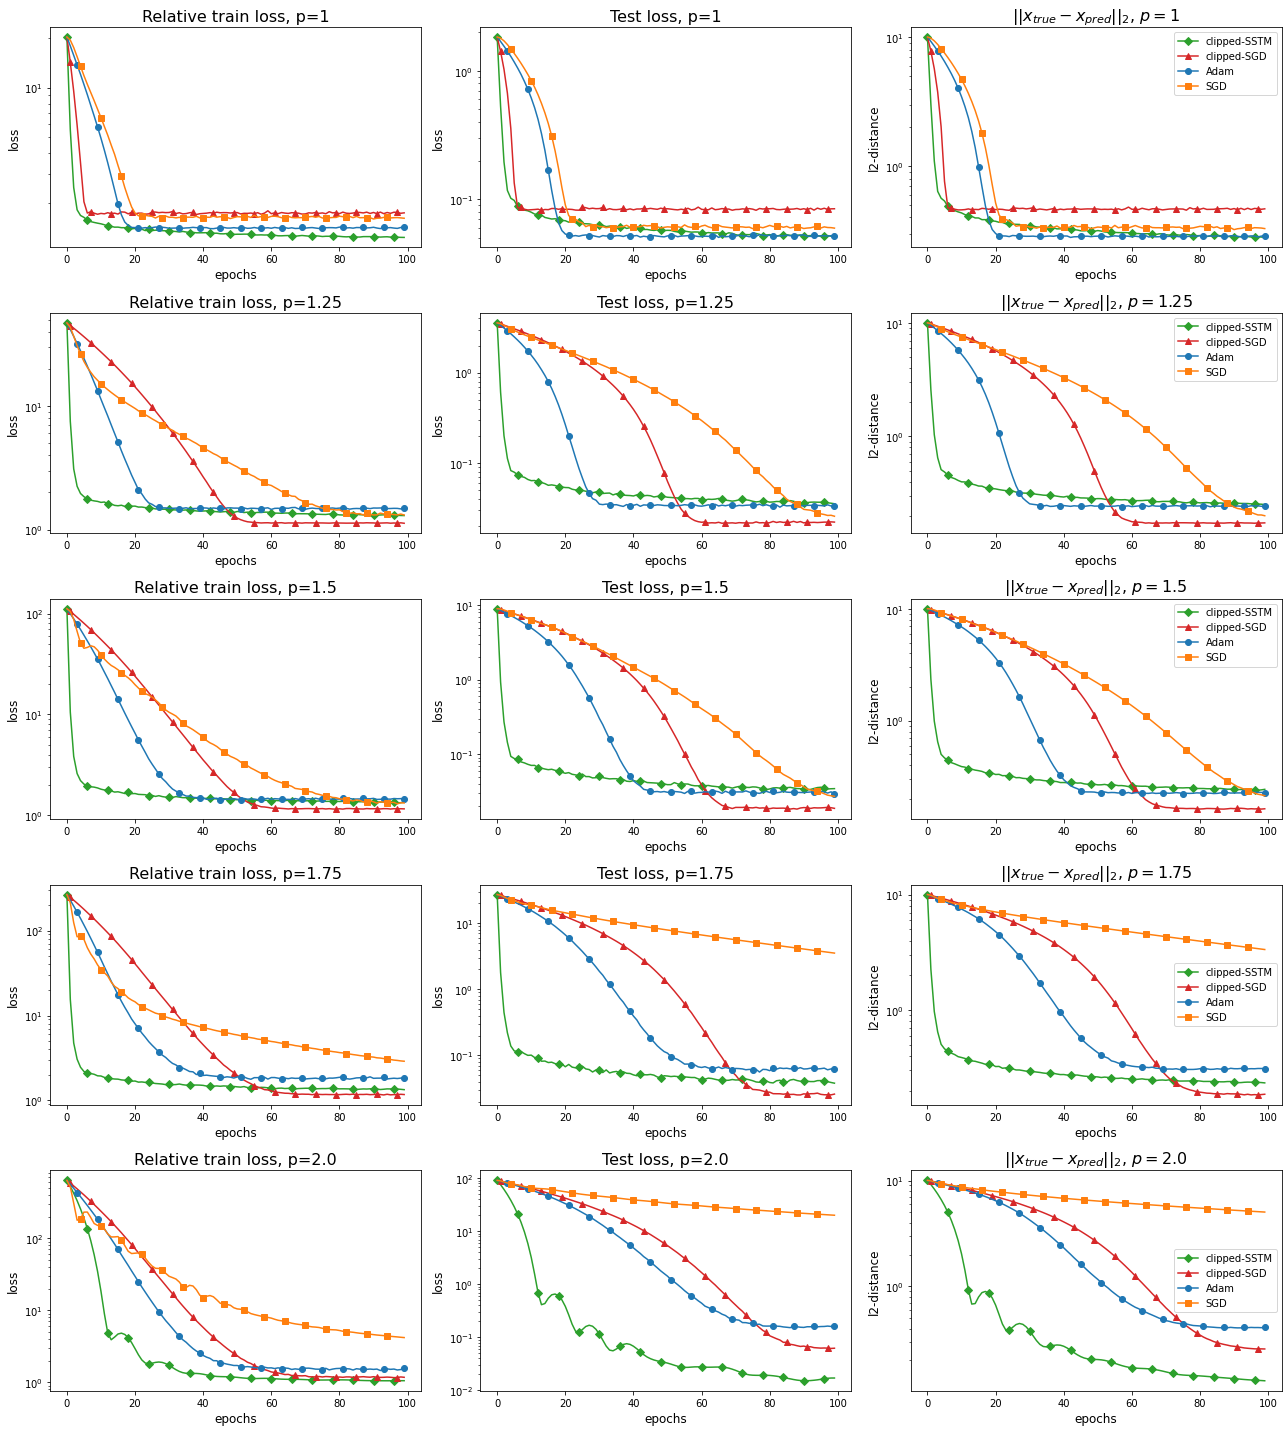

In [24]:
fig = plt.figure(figsize=(18,20))
gs = plt.GridSpec(5, 3, figure=fig)

for i,p in enumerate(ps):
    tasks_history_loaded = p_to_hist[p]
    tasks_history_loaded_grouped = group_uniques(tasks_history_loaded, norm_train=True)
 
    colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

    plot_params = {
     "adam": {
         "name": "Adam",
         "color": colors[0], "linestyle": "-",
         "marker": "o", "markevery": "auto"
     },
     "sgd": {
         "name": "SGD",
         "color": colors[1], "linestyle": "-",
         "marker": "s", "markevery": "auto"
     },
     "clipped_sstm": {
         "name": "clipped-SSTM",
         "color": colors[2], "linestyle": "-",
         "marker": "D", "markevery": "auto"
     },
     "clipped_sgd": {
         "name": "clipped-SGD",
         "color": colors[3], "linestyle": "-",
         "marker": "^", "markevery": "auto"
     },
    }

    ax2 = fig.add_subplot(gs[i, 0])

    make_loss_plot_with_plot_params(
        ax2, tasks_history_loaded_grouped, "train_losses_full", "Relative train loss, p={}".format(p + 1), 
        x_label="epochs", y_label="loss",
        start_x=0, alpha=0.9, linestyle="-", eps=1.0, y_scale="log", 
        plot_params=plot_params, mark_every_count=15, xy_label_fontsize=12, title_fontsize=16
    )

    ax3 = fig.add_subplot(gs[i, 1])

    make_loss_plot_with_plot_params(
        ax3, tasks_history_loaded_grouped, "test_losses", "Test loss, p={}".format(p + 1), 
        x_label="epochs", y_label="loss",
        start_x=0, alpha=0.9, linestyle="-", eps=1.0, y_scale="log", 
        plot_params=plot_params, mark_every_count=15, xy_label_fontsize=12, title_fontsize=16
    )

    ax4 = fig.add_subplot(gs[i, 2])

    make_loss_plot_with_plot_params(
        ax4, tasks_history_loaded_grouped, "pred_w_true_w_norm_diff", "$||x_{{true}} - x_{{pred}}||_2$, $p={}$".format(p + 1), 
        x_label="epochs", y_label="l2-distance",
        start_x=0, alpha=0.9, linestyle="-", eps=1.0, legend=True, y_scale="log", 
        plot_params=plot_params, mark_every_count=15, xy_label_fontsize=12, title_fontsize=16
    )

plt.tight_layout()

# PATH = './graphs/synth/best_by_x2_train_loss_p_{}_with_full_params.pdf'.format(p)
PATH = './graphs/synth/best_by_x2_train_loss.pdf'
plt.savefig(PATH, format='pdf')


In [25]:
hists_names_list = [
#     # 4, p = 0.00, 10 dataset splits, 5 runs for each split
    "2022-05-24_14_15_34_train_hist_p_0.0_selected_by_train_loss_full",
#     # 4, p = 0.25, 10 dataset splits, 5 runs for each split
    "2022-05-24_16_32_57_train_hist_p_0.25_selected_by_train_loss_full",
#     # 4, p = 0.50, 10 dataset splits, 5 runs for each split
    "2022-05-25_00_58_54_train_hist_p_0.5_selected_by_train_loss_full",
#     # 4, p = 0.75, 10 dataset splits, 5 runs for each split
    "2022-06-19_16_53_40_train_hist_p_0.75_selected_by_train_loss_full",
    # 4, p = 1.00, 10 dataset splits, 5 runs for each split
    "2022-05-26_01_44_28_train_hist_p_1.0_selected_by_train_loss_full"
]

ps = [0, 0.25, 0.5, 0.75, 1.0]

# hists_names_list = hists_names_list[::-1]

p_to_hist = {}
for p, hist_name in zip(ps, hists_names_list):
    p_to_hist[p] = hist_from_json(load_hist_jsons([hist_name], path="./results/synthetic"))

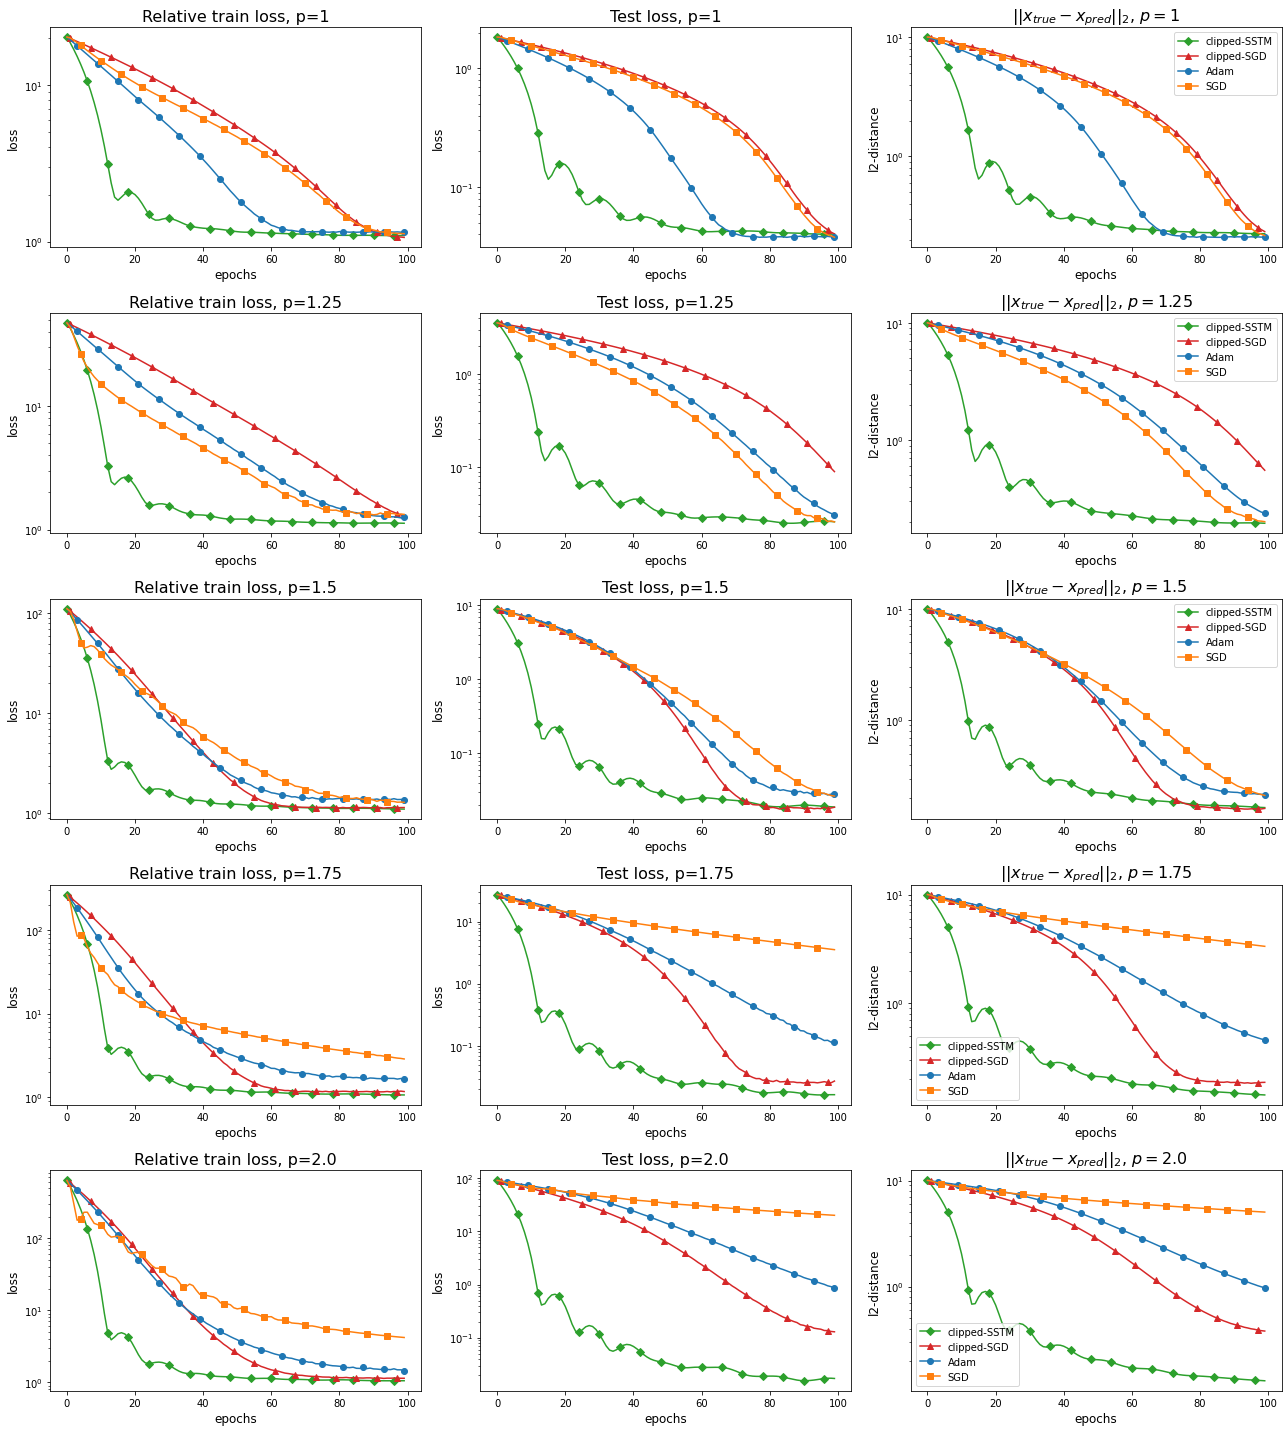

In [26]:
fig = plt.figure(figsize=(18,20))
gs = plt.GridSpec(5, 3, figure=fig)

for i,p in enumerate(ps):
    tasks_history_loaded = p_to_hist[p]
    tasks_history_loaded_grouped = group_uniques(tasks_history_loaded, norm_train=True)
 
    colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

    plot_params = {
     "adam": {
         "name": "Adam",
         "color": colors[0], "linestyle": "-",
         "marker": "o", "markevery": "auto"
     },
     "sgd": {
         "name": "SGD",
         "color": colors[1], "linestyle": "-",
         "marker": "s", "markevery": "auto"
     },
     "clipped_sstm": {
         "name": "clipped-SSTM",
         "color": colors[2], "linestyle": "-",
         "marker": "D", "markevery": "auto"
     },
     "clipped_sgd": {
         "name": "clipped-SGD",
         "color": colors[3], "linestyle": "-",
         "marker": "^", "markevery": "auto"
     },
    }

    ax2 = fig.add_subplot(gs[i, 0])

    make_loss_plot_with_plot_params(
        ax2, tasks_history_loaded_grouped, "train_losses_full", "Relative train loss, p={}".format(p + 1), 
        x_label="epochs", y_label="loss",
        start_x=0, alpha=0.9, linestyle="-", eps=1.0, y_scale="log", 
        plot_params=plot_params, mark_every_count=15, xy_label_fontsize=12, title_fontsize=16
    )

    ax3 = fig.add_subplot(gs[i, 1])

    make_loss_plot_with_plot_params(
        ax3, tasks_history_loaded_grouped, "test_losses", "Test loss, p={}".format(p + 1), 
        x_label="epochs", y_label="loss",
        start_x=0, alpha=0.9, linestyle="-", eps=1.0, y_scale="log", 
        plot_params=plot_params, mark_every_count=15, xy_label_fontsize=12, title_fontsize=16
    )

    ax4 = fig.add_subplot(gs[i, 2])

    make_loss_plot_with_plot_params(
        ax4, tasks_history_loaded_grouped, "pred_w_true_w_norm_diff", "$||x_{{true}} - x_{{pred}}||_2$, $p={}$".format(p + 1), 
        x_label="epochs", y_label="l2-distance",
        start_x=0, alpha=0.9, linestyle="-", eps=1.0, legend=True, y_scale="log", 
        plot_params=plot_params, mark_every_count=15, xy_label_fontsize=12, title_fontsize=16
    )

plt.tight_layout()

PATH = './graphs/synth/best_by_best_train_loss.pdf'
# PATH = './graphs/synth/best_by_best_train_loss_p_{}_with_full_params.pdf'.format(p)
plt.savefig(PATH, format='pdf')
